## Import Necessary Packages

In [2]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## User-Defined Fields

In [4]:
CONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/nn/configs.json'
with open(CONFIGSPATH,'r',encoding='utf-8') as f:
    CONFIGS = json.load(f)

FILEDIR    = CONFIGS['paths']['filedir']      
MODELDIR   = CONFIGS['paths']['modeldir']    
RESULTSDIR = CONFIGS['paths']['resultsdir']  
RUNS       = CONFIGS['runs']
SPLIT      = 'valid'
PRTHRESH   = 0.0

In [5]:
DEBUGDIR   = os.path.join(RESULTSDIR,'debug')
DEBUG_MODELS = [
    ('Mean','mean'),
    ('Linear','linear'),
    ('NN (Untrained)','nn_untrained'),
    ('NN (Trained)','nn_trained'),]

## Functions

In [38]:
def create_log_rain_bins(binspacing=0.08,minleftedge=0.001,maxcenter=1000):
    firstcenter = minleftedge/(1-binspacing/2)
    center      = firstcenter
    bincenters  = []
    binwidths   = []
    while center<=maxcenter:
        width = center*(binspacing)
        bincenters.append(center)
        binwidths.append(width)
        center  = center*(1+binspacing)
    bincenters  = np.array(bincenters)
    binwidths   = np.array(binwidths)
    binedges    = np.zeros(len(bincenters)+1)
    binedges[0] = bincenters[0]-binwidths[0]/2
    for i in range(len(bincenters)):
        binedges[i+1] = bincenters[i]+binwidths[i]/2
    return binedges

def get_r2(ytrueflat,ypredflat):
    mu  = ytrueflat.mean()
    rss = np.sum((ytrueflat-ypredflat)**2)
    tss = np.sum((ytrueflat-mu)**2)
    r2  = 1.0-(rss/tss)
    return np.nan if tss==0 else r2

def get_r2_spatial(ytrue,ypred,prthresh,positive=False):
    if positive: 
        mask = (ytrue>0)
        ytrue = ytrue.where(mask)
        ypred = ypred.where(mask)
    mu  = ytrue.mean('time',skipna=True)
    rss = ((ytrue-ypred)**2).sum('time',skipna=True)
    tss = ((ytrue-mu)**2).sum('time',skipna=True)
    nvalid = ytrue.count('time')
    r2 = xr.where((tss>0)&(nvalid>=2),1.0-(rss/tss),np.nan)
    return r2

def get_confusion_counts(ytrueflat,ypredflat,prthresh):
    trueabove = ytrueflat>prthresh
    predabove = ypredflat>prthresh
    TP = int(np.sum(predabove&trueabove))
    FP = int(np.sum(predabove&~trueabove))
    FN = int(np.sum(~predabove&trueabove))
    TN = int(np.sum(~predabove&~trueabove))
    return TP,FP,FN,TN

def _load_stats_for_denorm(filedir):
    with open(os.path.join(filedir,'stats.json'),'r',encoding='utf-8') as f:
        return json.load(f)

def _denorm_da_log1p_z(da_norm,stats):
    ylog = da_norm*float(stats['pr_std'])+float(stats['pr_mean'])
    y    = np.expm1(ylog)
    return xr.DataArray(np.clip(y,0.0,None),dims=da_norm.dims,coords=da_norm.coords,attrs={'units':'mm/day'})

## Load Data

In [7]:
truepath = os.path.join(FILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load() 

results = {}
for nicename,tag in DEBUG_MODELS:
    predpath = os.path.join(DEBUGDIR,f'debug_exp_1_{tag}_{SPLIT}_pr.nc')
    with xr.open_dataset(predpath,engine='h5netcdf') as ds:
        predpr = ds['predpr'].load()
    ytrue,ypred = xr.align(truepr,predpr,join='inner')
    results[tag] = dict(description=nicename,ytrue=ytrue,ypred=ypred)

## Observed vs. Predicted Precipitation

In [39]:
binedges  = create_log_rain_bins()
globalmin = float(binedges[0])
globalmax = float(binedges[-1])

paneldata  = [] 
for runname,result in results.items():
    description = result['description']
    ytrueflat   = result['ytrue'].values.ravel()
    ypredflat   = result['ypred'].values.ravel()
    mask  = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    r2all = get_r2(ytrueflat[mask],ypredflat[mask])
    posmask = mask*(ytrueflat>0.0)
    r2pos   = get_r2(ytrueflat[posmask],ypredflat[posmask])
    hist,_,_   = np.histogram2d(ytrueflat[posmask],ypredflat[posmask],bins=[binedges,binedges])
    hist       = np.ma.masked_where(hist==0,hist)
    paneldata.append((description,hist,r2all,r2pos))

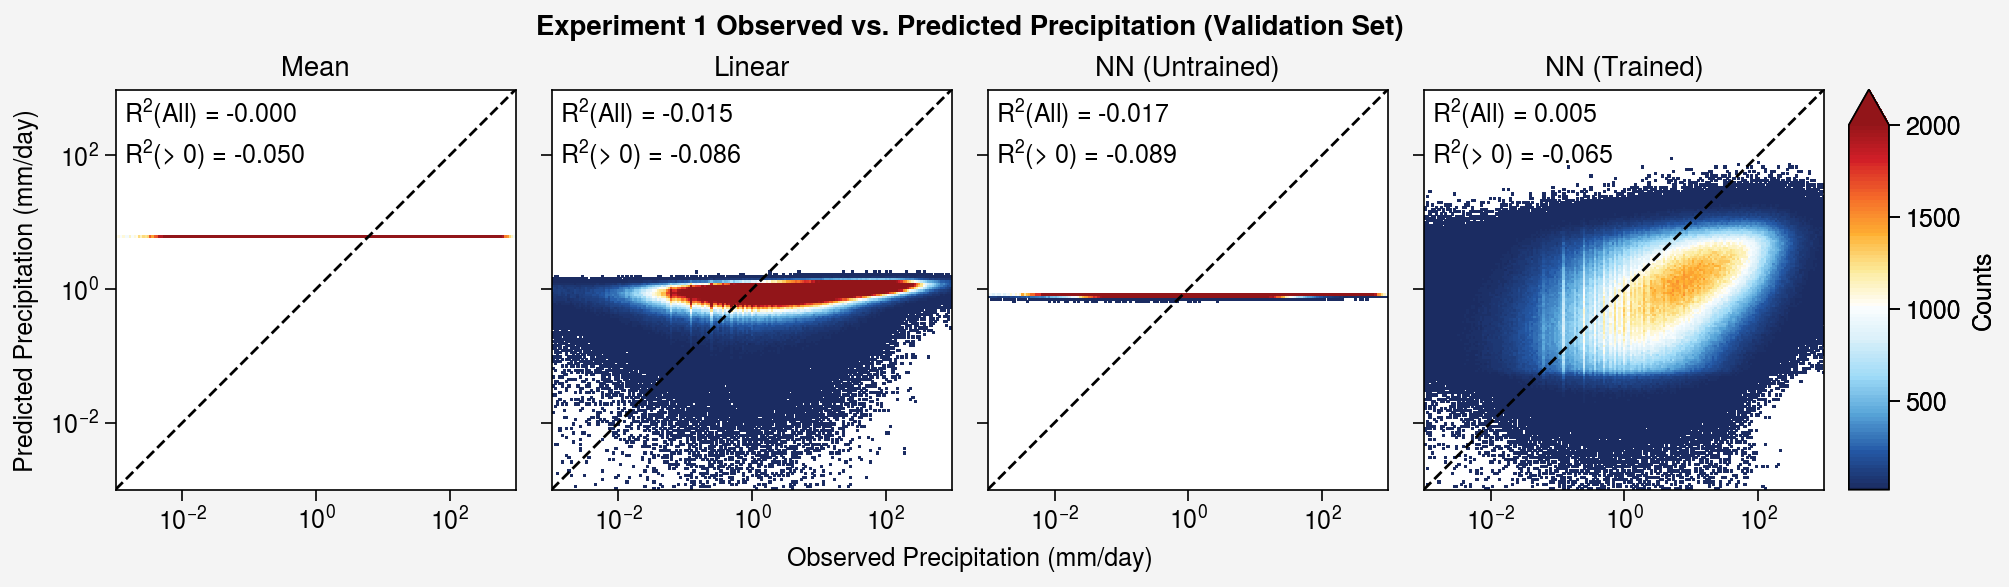

In [41]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=True)
axs.format(suptitle='Experiment 1 Observed vs. Predicted Precipitation (Validation Set)',
           xlabel='Observed Precipitation (mm/day)',xscale='log',xformatter='log',
           ylabel='Predicted Precipitation (mm/day)',yscale='log',yformatter='log')

im = None
for ax,(description,hist,r2all,r2pos) in zip(axs,paneldata):
    im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=2000,levels=100,extend='max')
    ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
    ax.text(0.02,0.98,f'R$^2$(All) = {r2all:.3f}\nR$^2$(> 0) = {r2pos:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description,
              xlim=(globalmin,globalmax),xticks=[1e-4,1e-2,1e0,1e2],xminorticks='none',
              ylim=(globalmin,globalmax),yticks=[1e-4,1e-2,1e0,1e2],yminorticks='none')

fig.colorbar(im,loc='r',label='Counts',ticks=[500,1000,1500,2000])
pplt.show()

## Observed vs. Predicted Precipitation Distributions

In [43]:
binedges  = create_log_rain_bins()

paneldata  = [] 
for runname,result in results.items():
    description = result['description']
    ytrueflat = result['ytrue'].values.ravel()
    ypredflat = result['ypred'].values.ravel()
    mask = np.isfinite(ytrueflat)&np.isfinite(ypredflat)&(ytrueflat>0)
    r2   = get_r2(ytrueflat[mask],ypredflat[mask])
    paneldata.append((description,r2,ytrueflat,ypredflat))

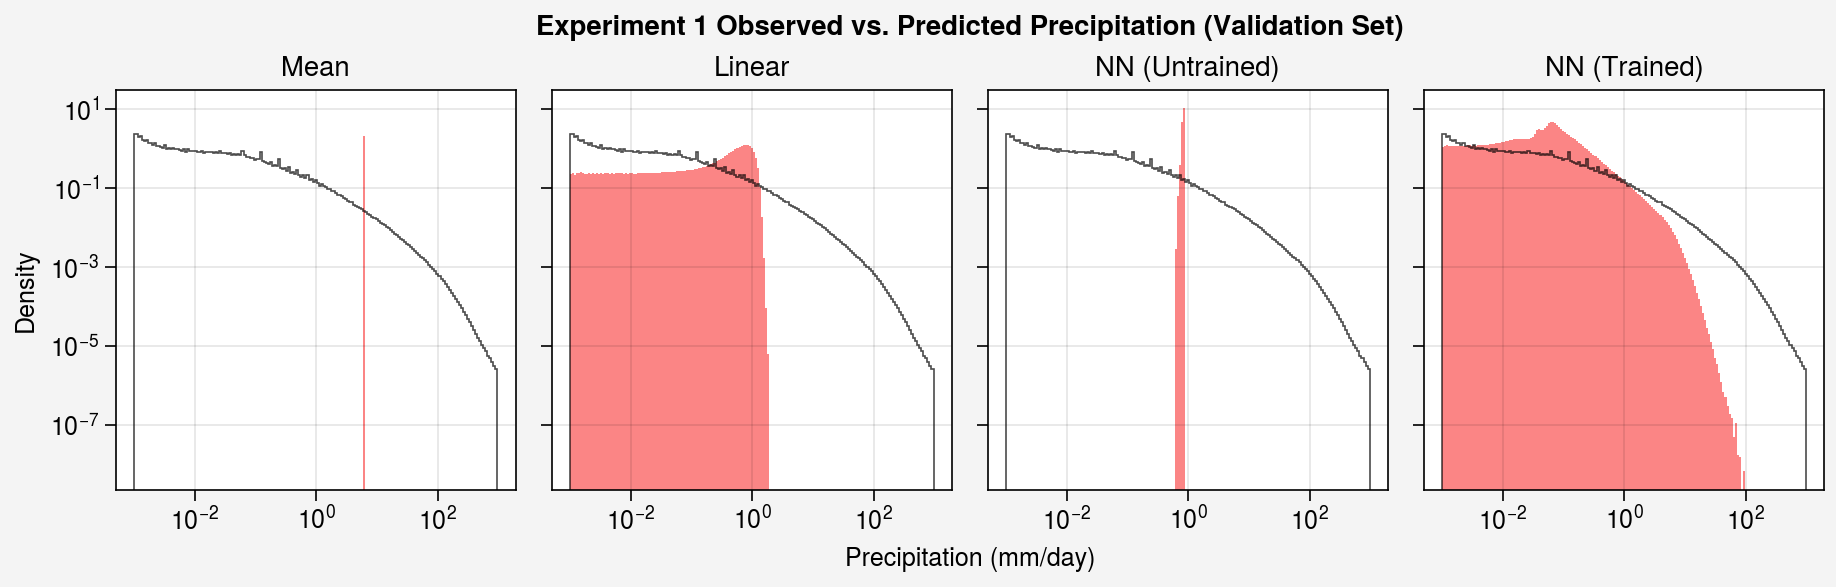

In [44]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=True)
axs.format(suptitle='Experiment 1 Observed vs. Predicted Precipitation (Validation Set)',
           xlabel='Precipitation (mm/day)',xscale='log',xformatter='log',ylabel='Density',yscale='log',yformatter='log')

for ax,(description,r2,ytrueflat,ypredflat) in zip(axs,paneldata):
    ax.hist(ytrueflat,bins=binedges,density=True,histtype='step',color='k',alpha=0.7,label='Observed')
    ax.hist(ypredflat,bins=binedges,density=True,color='red6',alpha=0.7,label='Predicted')
    # ax.text(0.02,0.98,f'R$^2$(>0 ) = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description)
    
pplt.show()

## Precipitation Comparison

In [46]:
# %% [markdown]
# # Verify Denormalization of Validation Precipitation
#
# This notebook checks that denormalizing the **z-scored log1p precipitation** (`pr`) in
# `norm_valid.h5` correctly recovers precipitation in **mm/day**, and (if available) matches
# the physical `pr` values in a corresponding `valid.h5`.
#
# **What it does:**
# 1. Load `norm_valid.h5` (`pr` is z-scored log1p).
# 2. Load `stats.json` to get normalization parameters (`pr_mean`, `pr_std`).
# 3. Denormalize to mm/day: `y = expm1( pr_z * std + mean )`.
# 4. If a physical `valid.h5` exists, align and compare: RMSE/MAE/MaxAbs.
# 5. Round-trip check (normalize the denormalized `y` back to `z` and compare with the original `pr_z`).
#
# If the processed `valid.h5` isn't found, the notebook still performs the round-trip check
# to verify consistency.

# %%
import os
import json
import warnings
import numpy as np
import xarray as xr

warnings.filterwarnings('ignore')

# Paths
CONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/nn/configs.json'
with open(CONFIGSPATH, 'r', encoding='utf-8') as f:
    CONFIGS = json.load(f)

FILEDIR_SPLITS = CONFIGS['paths']['filedir']        # e.g., .../data/splits
STATS_PATH     = os.path.join(FILEDIR_SPLITS, 'stats.json')

# Heuristic guess for processed dir (where physical valid.h5 may live)
# Adjust if your layout differs.
PROCESSED_DIR  = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/splits'

SPLIT_NORM = 'norm_valid.h5'   # normalized file in splits dir
SPLIT_RAW  = 'valid.h5'        # physical file in processed dir (if present)

# Validation period used elsewhere in your pipeline
START_DATE = '2015-06-01'
END_DATE   = '2015-08-31'

# %%
def denorm_log1p_z(da_z, stats):
    """
    Invert z-score(log1p) normalization to physical units (mm/day).

    Parameters
    ----------
    da_z : xr.DataArray
        z-scored log1p precipitation.
    stats : dict
        Contains 'pr_mean' and 'pr_std' (statistics of log1p(pr)).
    """
    mean = float(stats['pr_mean'])
    std  = float(stats['pr_std'])
    ylog = da_z * std + mean
    y    = np.expm1(ylog)
    y    = xr.DataArray(np.clip(y, 0.0, None), dims=da_z.dims, coords=da_z.coords,
                        name='pr_denorm', attrs={'units': 'mm/day'})
    return y

def renorm_log1p(da_phys, stats):
    """Apply log1p + z-score to physical precipitation (mm/day)."""
    mean = float(stats['pr_mean'])
    std  = float(stats['pr_std'])
    ylog = np.log1p(np.clip(da_phys, 0.0, None))
    yz   = (ylog - mean) / std
    yz   = xr.DataArray(yz, dims=da_phys.dims, coords=da_phys.coords, name='pr_z')
    return yz

def summarize_diff(y_true, y_pred, label=''):
    """Print RMSE/MAE/MaxAbs and return a dict."""
    y_true_v = y_true.values.ravel()
    y_pred_v = y_pred.values.ravel()
    mask = np.isfinite(y_true_v) & np.isfinite(y_pred_v)
    if mask.sum() == 0:
        print(f"[{label}] No overlapping finite values.")
        return {'n': 0, 'rmse': np.nan, 'mae': np.nan, 'max_abs': np.nan}
    diff = y_pred_v[mask] - y_true_v[mask]
    rmse = float(np.sqrt(np.mean(diff**2)))
    mae  = float(np.mean(np.abs(diff)))
    mxa  = float(np.max(np.abs(diff)))
    print(f"[{label}] n={mask.sum():,}  RMSE={rmse:.6g}  MAE={mae:.6g}  MaxAbs={mxa:.6g}")
    return {'n': int(mask.sum()), 'rmse': rmse, 'mae': mae, 'max_abs': mxa}

# %%
# Load normalized validation precip (z-scored log1p)
norm_path = os.path.join(FILEDIR_SPLITS, SPLIT_NORM)
with xr.open_dataset(norm_path, engine='h5netcdf') as ds_norm:
    pr_z = ds_norm['pr'].sel(time=slice(START_DATE, END_DATE)).load()

# Load stats for (log1p) normalization
with open(STATS_PATH, 'r', encoding='utf-8') as f:
    stats = json.load(f)

# Denormalize to physical mm/day
pr_denorm = denorm_log1p_z(pr_z, stats)
pr_denorm

# %%
# Optional: compare with processed valid.h5 if available
raw_path = os.path.join(PROCESSED_DIR, SPLIT_RAW)
if os.path.exists(raw_path):
    print(f"Found physical validation file: {raw_path}")
    with xr.open_dataset(raw_path, engine='h5netcdf') as ds_raw:
        pr_phys = ds_raw['pr'].sel(time=slice(START_DATE, END_DATE)).load()
    
    # Align on (time, lat, lon)
    pr_denorm_aligned, pr_phys_aligned = xr.align(pr_denorm, pr_phys, join='inner')
    print("Aligned shapes:", pr_denorm_aligned.shape, pr_phys_aligned.shape)
    
    # Summary differences in mm/day
    _ = summarize_diff(pr_phys_aligned, pr_denorm_aligned, label='Phys vs Denorm(norm_valid)')
else:
    print(f"Physical validation file not found at: {raw_path}\nSkipping direct file-to-file comparison.")

# %%
# Round-trip: denorm -> renorm should recover pr_z
pr_rez = renorm_log1p(pr_denorm, stats)

# Align (should already match)
pr_z_a, pr_rez_a = xr.align(pr_z, pr_rez, join='inner')
_ = summarize_diff(pr_z_a, pr_rez_a, label='Round-trip: pr_z vs renorm(denorm(pr_z))')

# Show a few stats for sanity
print("\nSanity stats (validation window):")
print("pr_z      ", float(pr_z_a.mean().values), float(pr_z_a.std().values))
print("pr_rez    ", float(pr_rez_a.mean().values), float(pr_rez_a.std().values))
print("pr_mm/day ", float(pr_denorm.mean().values), float(pr_denorm.std().values))

# %%
# If physical file exists, quick correlation on a few random grid cells (no plots, just numbers).
if os.path.exists(raw_path):
    rng = np.random.default_rng(42)
    # pick up to 5 random valid grid points
    lat = pr_denorm['lat'].values
    lon = pr_denorm['lon'].values
    nlat = len(lat); nlon = len(lon)
    idxs = [(rng.integers(0, nlat), rng.integers(0, nlon)) for _ in range(min(5, nlat*nlon))]
    print("\nSample gridpoint correlations (mm/day):")
    for (i, j) in idxs:
        a = pr_phys_aligned[:, i, j].values
        b = pr_denorm_aligned[:, i, j].values
        m = np.isfinite(a) & np.isfinite(b)
        if m.sum() >= 3:
            corr = np.corrcoef(a[m], b[m])[0, 1]
            print(f"  (lat={lat[i]:.3f}, lon={lon[j]:.3f})  n={m.sum():3d}  corr={corr:.3f}")
        else:
            print(f"  (lat={lat[i]:.3f}, lon={lon[j]:.3f})  insufficient overlap")


Found physical validation file: /global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/splits/valid.h5
Aligned shapes: (2208, 81, 121) (2208, 81, 121)
[Phys vs Denorm(norm_valid)] n=21,640,608  RMSE=7.32206e-06  MAE=6.80528e-07  MaxAbs=0.00170898
[Round-trip: pr_z vs renorm(denorm(pr_z))] n=21,640,608  RMSE=7.2274e-09  MAE=4.07963e-10  MaxAbs=2.38419e-07

Sanity stats (validation window):
pr_z       0.0010300506837666035 0.9222222566604614
pr_rez     0.0010300506837666035 0.9222222566604614
pr_mm/day  5.610373020172119 36.390377044677734

Sample gridpoint correlations (mm/day):
  (lat=6.750, lon=83.250)  n=2208  corr=1.000
  (lat=18.250, lon=73.250)  n=2208  corr=1.000
  (lat=13.750, lon=85.750)  n=2208  corr=1.000
  (lat=6.500, lon=81.000)  n=2208  corr=1.000
  (lat=9.000, lon=62.750)  n=2208  corr=1.000
